# Convolutional Neural Network

Convolutional neural networks have shown strong performance on image classification. The convolutional neural network generally begins with one or more convolutional layers. These layers convolve the image in its native format (ie. not flattenned as in a standard feed forward network) with a filter, initialized with random weights. The outputs of the convolutional layers are downsampled via a technique called max pooling which just selects the maximum value in a user defined sliding grid space. This makes things more computationally efficient, imparts regularization, and also, by repeatedly downsampling, larger and more complex features can be detected without increasing the convolutional filter size. Finally, the convolutional layer outputs are flattened and fed into a standard feed forward neural network with dense layers. All weights, including those of the convolutional filters, are optimized by back propogation. In this way the neural network learns relevant filters. 

In [2]:
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
import pickle

In [3]:
traindata = pd.DataFrame(pickle.load(open('data\TrainData.p','rb')))
traindata = traindata.sample(n = len(traindata))
testdata = pd.DataFrame(pickle.load(open('data\TestData.p','rb')))

In [4]:
Xtrain, ytrain = traindata.iloc[:,0:2304].as_matrix(), traindata.iloc[:,2304]
Xtest, ytest = testdata.iloc[:,0:2304].as_matrix(), testdata.iloc[:,2304]

The shape of images is now important because the convolutional filters developed in the 2d convolutional layer  will traverse across the image in its natural orientation. We'll reshape each image to be 48x48x1 (since these are grey scale images). Each image will also be stacked into this array, for a Nimages x 48 x 48 x 1 array.

In [5]:
Xtrain, Xtest = Xtrain.reshape(len(Xtrain),48,48,1) , Xtest.reshape(len(Xtest),48,48,1)

In [6]:
Xtrain.shape

(31761, 48, 48, 1)

In [7]:
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

In [8]:
optimizer = SGD(lr=1e-4, momentum=0.9)
#optimizer = Adam()

In [9]:
def plot_epochs(history):
    plt.plot(history.history['categorical_accuracy'], label = 'training accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label = 'validation accuracy')
    plt.legend()

Here the network is defined. This network uses 2 convolutional layers.

In [81]:
model = Sequential()
model.add(Conv2D(16,(4,4), input_shape = (48,48,1), activation = 'relu',data_format = "channels_last"))
conv1 = model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32,(4,4),activation = 'relu', data_format="channels_last"))
conv2 = model.add(MaxPool2D( pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000))
model.add(Dropout(.5))
model.add(Activation('relu'))
model.add(Dense(500))
model.add(Dropout(.5))
model.add(Activation('relu'))
model.add(Dense(7))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [82]:
history = model.fit(Xtrain,ytrain, epochs = 15,verbose = 1,validation_split=.2,batch_size=100)

Train on 25408 samples, validate on 6353 samples
Epoch 1/15
25408/25408 [==============================] - 3s 130us/step - loss: 1.7581 - categorical_accuracy: 0.3071 - val_loss: 1.6428 - val_categorical_accuracy: 0.3844
Epoch 2/15
25408/25408 [==============================] - 3s 104us/step - loss: 1.4332 - categorical_accuracy: 0.4578 - val_loss: 1.3175 - val_categorical_accuracy: 0.5024
Epoch 3/15
25408/25408 [==============================] - 3s 104us/step - loss: 1.2303 - categorical_accuracy: 0.5323 - val_loss: 1.1963 - val_categorical_accuracy: 0.5404
Epoch 4/15
25408/25408 [==============================] - 3s 103us/step - loss: 1.1081 - categorical_accuracy: 0.5791 - val_loss: 1.1823 - val_categorical_accuracy: 0.5487
Epoch 5/15
25408/25408 [==============================] - 3s 105us/step - loss: 1.0147 - categorical_accuracy: 0.6186 - val_loss: 1.1388 - val_categorical_accuracy: 0.5629
Epoch 6/15
25408/25408 [==============================] - 3s 104us/step - loss: 0.9110 - ca

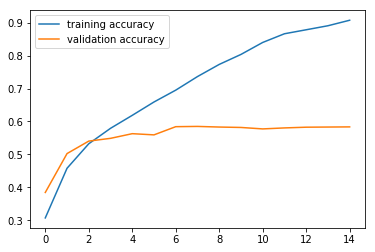

In [83]:
plot_epochs(history)

The model trains much faster than the standard non-convolutional feed forward networks tested before. It's also more readily interpretable. We can see what filters the network develops and what features they detect.

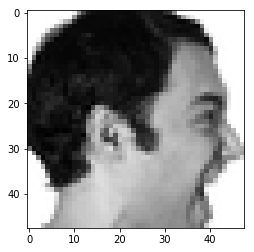

In [87]:
image = Xtrain[0,:,:,:].reshape(1,48,48,1)
plt.imshow(image.reshape(48,48),cmap = 'gray') # one random image

This code gets the output of every layer

In [88]:
outputs = [layer.output for layer in model.layers]
funcs = [K.function([model.input] + [K.learning_phase()], [out]) for out in outputs]
list_inputs = [image,0.]
layer_outputs = [func(list_inputs)[0] for func in funcs]

We can grab the first convolutional layer weights and check out what filters were learned.

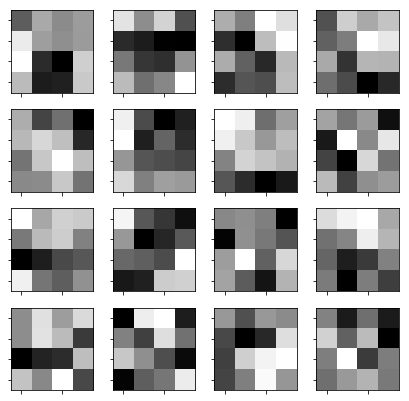

In [89]:
fig, axes = plt.subplots(4,4,figsize=(7,7))
axes = axes.flatten()
c1_weights = (model.layers[0].get_weights())[0]

for index, ax in enumerate(axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    filt = c1_weights.squeeze()[:,:,index]
    ax.imshow(filt, cmap = 'gray')

Now let's see what the image looks like after be convolved with each filter.

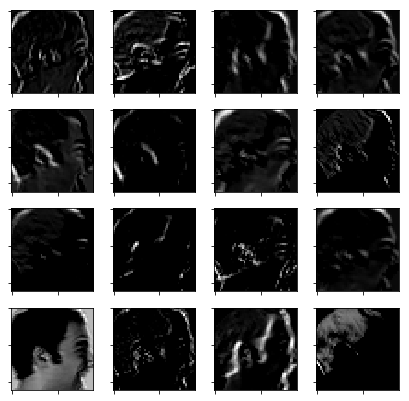

In [90]:
fig, axes = plt.subplots(4,4,figsize=(7,7))
axes = axes.flatten()
for index, ax in enumerate(axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.imshow(layer_outputs[0].squeeze()[:,:,index],
              cmap = 'gray',interpolation='none')

We can see various forms of edge detection that the neural network optimized on its own! We can also view the effect of maxpool downsampling here.

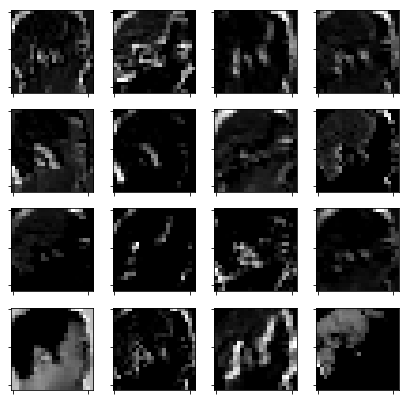

In [91]:
fig, axes = plt.subplots(4,4,figsize=(7,7))
axes = axes.flatten()
for index, ax in enumerate(axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.imshow(layer_outputs[1].squeeze()[:,:,index],
              cmap = 'gray',interpolation='none')

As expected they resemple the maps above but are more pixelated and emphasize areas where activation has occured. We can also look at the second convolutional layer weights.

In [19]:
c2_weights = (model.layers[2].get_weights())[0]

In [21]:
c2_weights.shape

(5, 5, 16, 32)

As can be seen there are a lot more of them. We define 32 outputs (32 filters) and there are 16 inputs. I'll just show a sample of 64 outputs below.

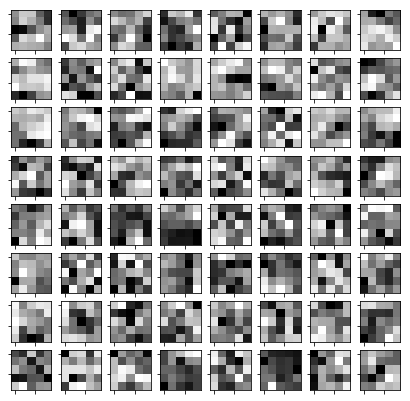

In [92]:
fig, axes = plt.subplots(8,8,figsize=(7,7))
axes = axes.flatten()

for index, ax in enumerate(axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    filt = c2_weights.squeeze()[:,:,index//32, index if index < 32 else index-32]
    ax.imshow(filt, cmap = 'gray')

Now we can visualize the second layer outputs

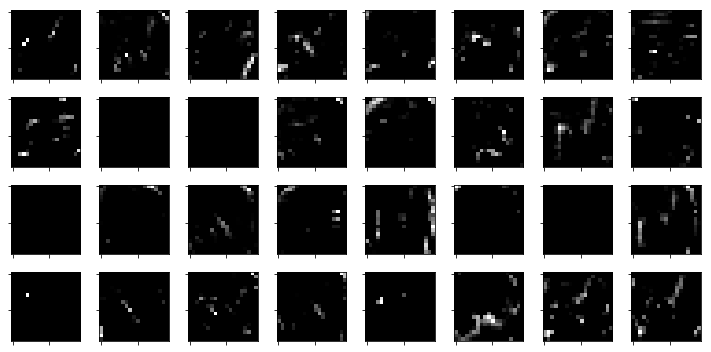

In [93]:
fig, axes = plt.subplots(4,8,figsize=(10,5))
axes = axes.flatten()
for index, ax in enumerate(axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.imshow(layer_outputs[2].squeeze()[:,:,index],
              cmap = 'gray',interpolation='none')

plt.tight_layout()

It's a lot less clear what the network has learned. We can see some edges and small regions of activations. Now we can see what they finally downsample to.

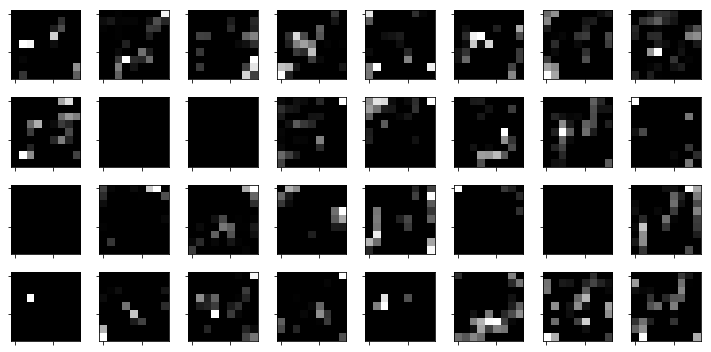

In [94]:
fig, axes = plt.subplots(4,8,figsize=(10,5))
axes = axes.flatten()
for index, ax in enumerate(axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.imshow(layer_outputs[3].squeeze()[:,:,index],
              cmap = 'gray',interpolation='none')

plt.tight_layout()

Now it is largely uninterpretable at least by my eye, but we can see some features have been detected. These get flattenned out and go through the network as per usual now. Since the "important" features have been smoothed out and collected by convolution and max pooling, the results are much stronger than in a non-convolutional network.

In [95]:
preds = np.argmax(model.predict(Xtest),axis = 1)
print(classification_report(y_true = np.argmax(ytest,axis=1), y_pred = preds))
print('\n')
print('accuracy', np.round(np.mean(preds ==  np.argmax(ytest,axis=1)),2))
print('\n')
print('confusion matrix')
print(confusion_matrix(y_true =  np.argmax(ytest,axis=1), y_pred = preds))

             precision    recall  f1-score   support

          0       0.45      0.44      0.44       958
          1       0.61      0.50      0.55       111
          2       0.46      0.34      0.39      1024
          3       0.73      0.74      0.73      1774
          4       0.41      0.51      0.46      1247
          5       0.77      0.68      0.73       831
          6       0.48      0.51      0.49      1233

avg / total       0.56      0.55      0.55      7178



accuracy 0.55


confusion matrix
[[ 425    9   80   96  207   20  121]
 [  23   56    7    6   13    1    5]
 [ 131    8  345   82  246   78  134]
 [  84    5   50 1306  138   30  161]
 [ 146    7  107  108  636   18  225]
 [  29    1   93   58   36  567   47]
 [ 117    6   65  130  266   19  630]]
